##Chunk1

In [86]:
import os,sys,warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(style='whitegrid')
%matplotlib inline

##Chunk2

In [87]:
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge as BR
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge




##Chunk3(load the dataset "housing.csv")

In [88]:
# prompt: load the dataset "housing.csv"

df = pd.read_csv('housing.csv')
print(df.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


##Chunk4(Apply OneHotEncoding to 'ocean_proximity')

In [89]:
# Apply OneHotEncoding to 'ocean_proximity'
# drop_first=True avoids the dummy variable trap (redundant column)
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

# Save the updated DataFrame to a new CSV file
df.to_csv('housing_encoded.csv', index=False)


##Chunk5( show missing values in columns of the dataset)

In [90]:
# prompt: show missing values in columns of the dataset "housing_encoded.csv" (after OneHotEncoding)

import pandas as pd

# Load the updated dataset with OneHotEncoded variables
df_encoded = pd.read_csv('housing_encoded.csv')

# Check for missing values in each column
missing_values = df_encoded.isnull().sum()

# Print only columns with missing values (if any)
print("Missing values per column:")
print(missing_values[missing_values > 0])



Missing values per column:
total_bedrooms    207
dtype: int64


##Chunk6

In [91]:
from sklearn.neighbors import KNeighborsRegressor

# function that imputes a dataframe
def impute_knn(df_encoded):

    ''' inputs: pandas df containing feature matrix '''
    ''' outputs: dataframe with NaN imputed '''
    # imputation with KNN unsupervised method

    # separate dataframe into numerical/categorical
    ldf = df_encoded.select_dtypes(include=[np.number])           # select numerical columns in df
    ldf_putaside = df_encoded.select_dtypes(exclude=[np.number])  # select categorical columns in df
    # define columns w/ and w/o missing data
    cols_nan = ldf.columns[ldf.isna().any()].tolist()         # columns w/ nan
    cols_no_nan = ldf.columns.difference(cols_nan).values     # columns w/o nan

    for col in cols_nan:
        imp_test = ldf[ldf[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ldf.dropna()          # all indices which which have no missing data
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])

    return pd.concat([ldf,ldf_putaside],axis=1)

##Chunk7(Filling missing values)

In [92]:
# Call function that imputes missing data
df2 = impute_knn(df_encoded)
# looks like we have a full feature matrix
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   ocean_proximity_INLAND      20640 non-null  bool   
 10  ocean_proximity_ISLAND      20640 non-null  bool   
 11  ocean_proximity_NEAR BAY    20640 non-null  bool   
 12  ocean_proximity_NEAR OCEAN  20640 non-null  bool   
dtypes: bool(4), float64(9)
memory u

##Chunk8(we normalized numerical variables. We alreday excluded both target variable and onehot encoded variable.)

In [93]:

# prompt: normalize the variables of "housing_encoded.csv"
#         but EXCLUDE 'median_house_value' and OneHotEncoded ocean_proximity columns from the final result

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df_encoded = pd.read_csv('housing_encoded.csv')

# Automatically detect ocean_proximity dummy columns
ocean_proximity_cols = [col for col in df_encoded.columns if col.startswith('ocean_proximity_')]

# Define columns to exclude
exclude_cols = ['median_house_value'] + ocean_proximity_cols

# Select features to normalize (drop excluded columns)
features_to_normalize = df_encoded.drop(columns=exclude_cols)

# Normalize
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features_to_normalize)

# Create DataFrame for normalized features only
normalized_df = pd.DataFrame(normalized_features, columns=features_to_normalize.columns)

# Display result (only normalized numeric features, without target or one-hot vars)
print(normalized_df.head())




   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.211155  0.567481            0.784314     0.022331        0.019863   
1   0.212151  0.565356            0.392157     0.180503        0.171477   
2   0.210159  0.564293            1.000000     0.037260        0.029330   
3   0.209163  0.564293            1.000000     0.032352        0.036313   
4   0.209163  0.564293            1.000000     0.041330        0.043296   

   population  households  median_income  
0    0.008941    0.020556       0.539668  
1    0.067210    0.186976       0.538027  
2    0.013818    0.028943       0.466028  
3    0.015555    0.035849       0.354699  
4    0.015752    0.042427       0.230776  


##Chunk9(Plotting box plots for Normalized numerical variables.)

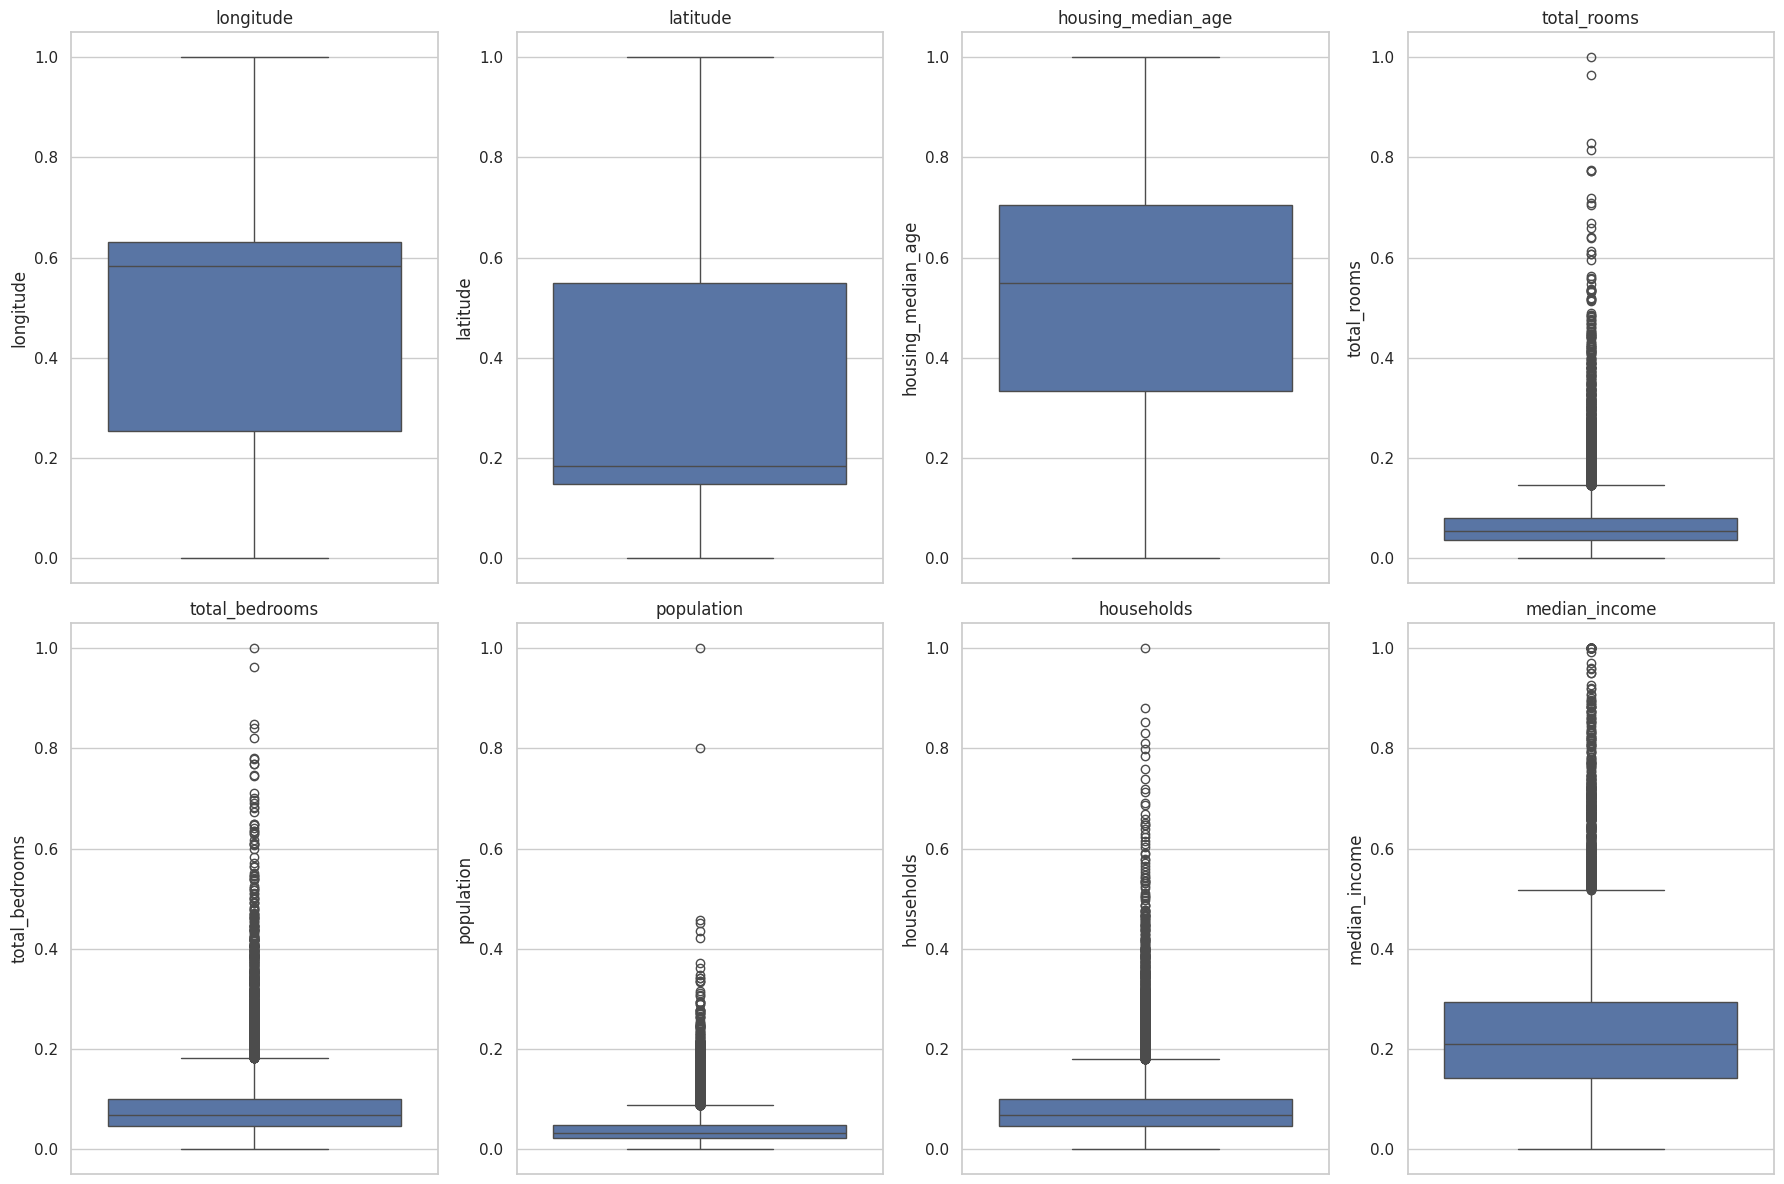

In [94]:
# prompt: now show the box plot for only normalized numerical feature variables

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use normalized_df directly (already excludes target + one-hot encoded vars)
final_df = normalized_df.copy()

# Create box plots for each numeric feature
plt.figure(figsize=(18, 12))
num_cols = 4
num_rows = int(np.ceil(len(final_df.columns) / num_cols))

for i, col in enumerate(final_df.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=final_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()



##Chunk10(Removing the out layers of numerical variables. at the end, we concatenated the target variable "median_house_value" to the box plots, but we did not remove the out layers of the target variable.)

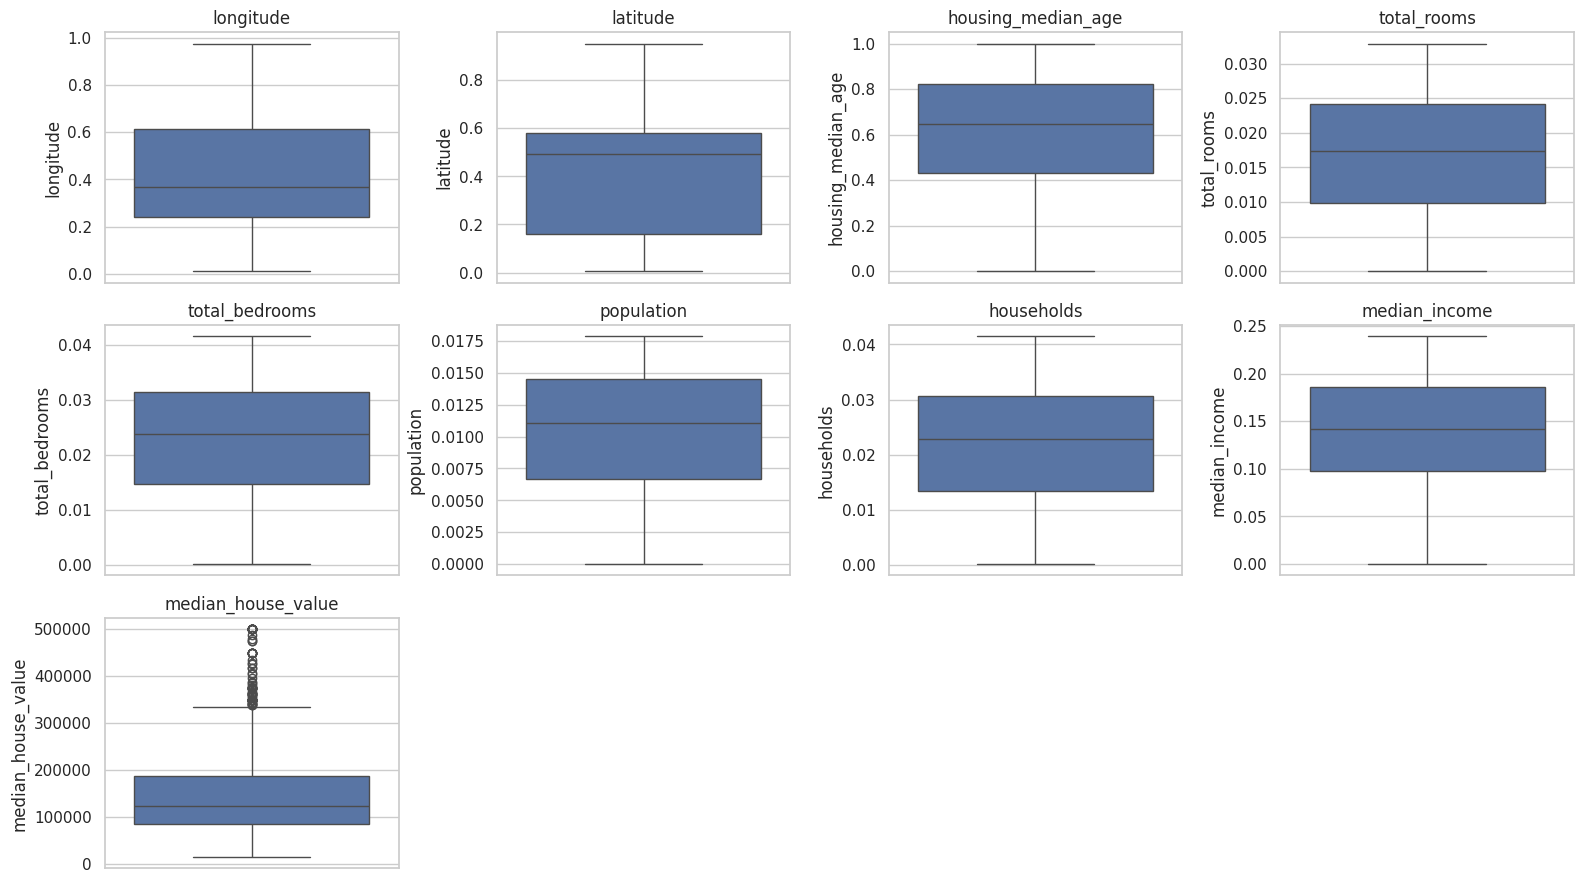

In [95]:
# prompt: remove outliers based on thresholds and display box plots (including median_house_value)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Combine normalized features with target column for filtering & plotting
final_df = pd.concat([normalized_df, df_encoded[['median_house_value']]], axis=1)

# Define quantile thresholds for filtering (from normalized features only)
q1 = final_df['total_rooms'].quantile(0.2)
q2 = final_df['total_bedrooms'].quantile(0.2)
q3 = final_df['population'].quantile(0.16)
q4 = final_df['households'].quantile(0.2)
q5 = final_df['median_income'].quantile(0.6)

# Apply filtering for outlier removal (median_house_value is retained)
filtered_df = final_df[
    (final_df['total_rooms'] < q1) &
    (final_df['total_bedrooms'] < q2) &
    (final_df['population'] < q3) &
    (final_df['households'] < q4) &
    (final_df['median_income'] < q5)
]

# Plot box plots for all numeric columns including the target
numeric_cols = filtered_df.select_dtypes(include=np.number).columns
num_features = len(numeric_cols)
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))

plt.figure(figsize=(num_cols * 4, num_rows * 3))
for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=filtered_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()





##Chunk11(Displaying Histgram)

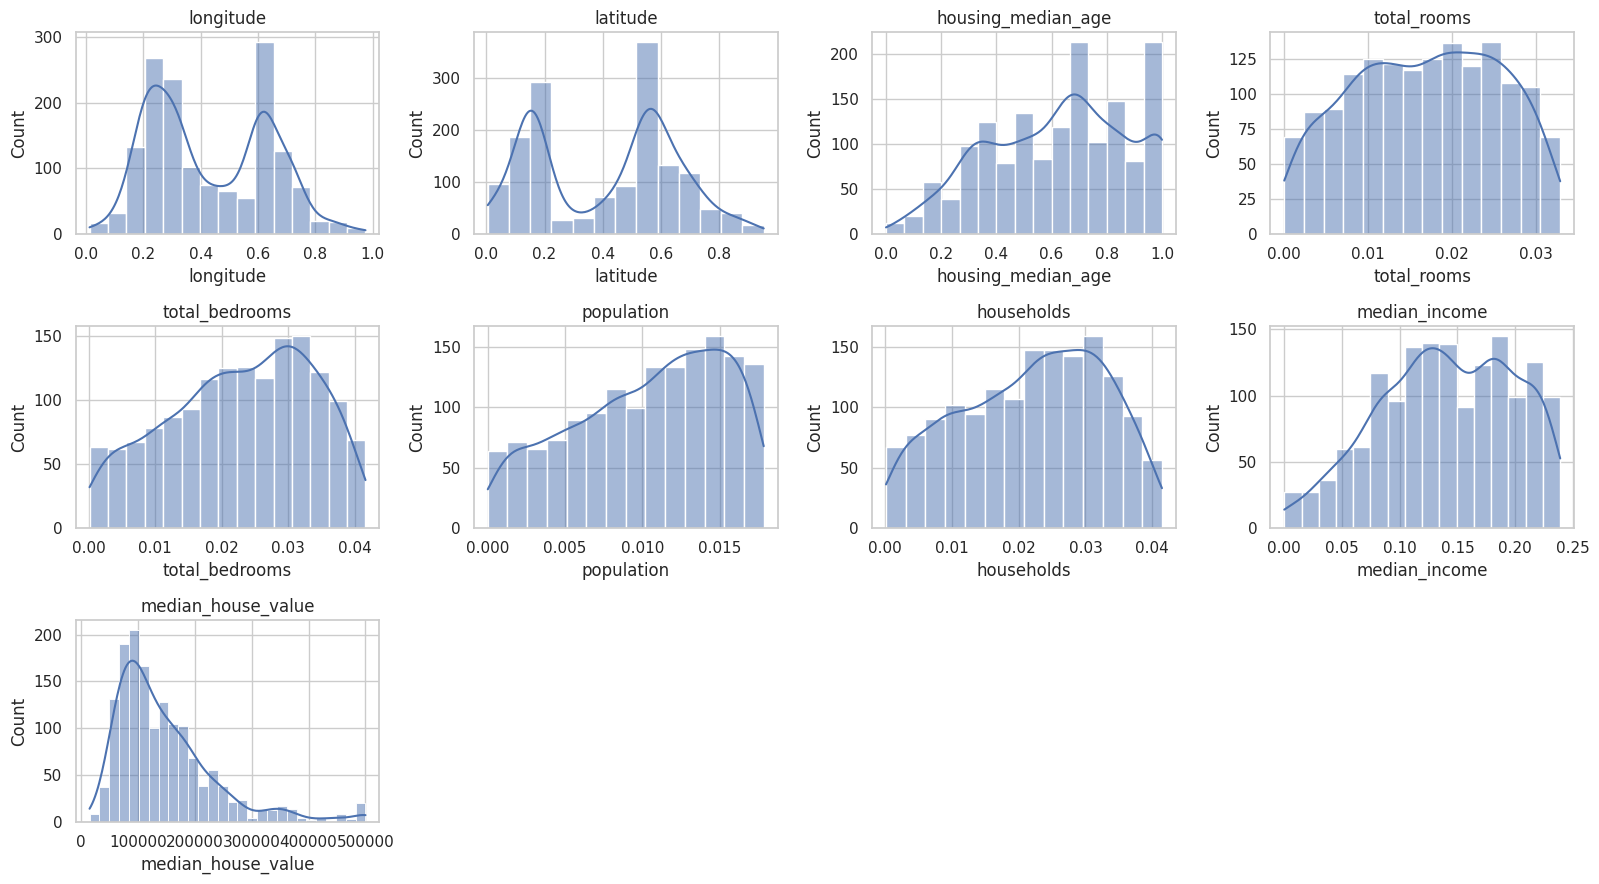

In [96]:
# prompt: now display the histograms for all numeric variables (dynamic layout)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get numeric columns
numeric_cols = filtered_df.select_dtypes(include=np.number).columns
num_features = len(numeric_cols)
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))

# Create histograms
plt.figure(figsize=(num_cols * 4, num_rows * 3))
for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(filtered_df[col], kde=True)  # kde=True to smooth density
    plt.title(col)

plt.tight_layout()
plt.show()



##Chunk12(Plotting correlation heat map)

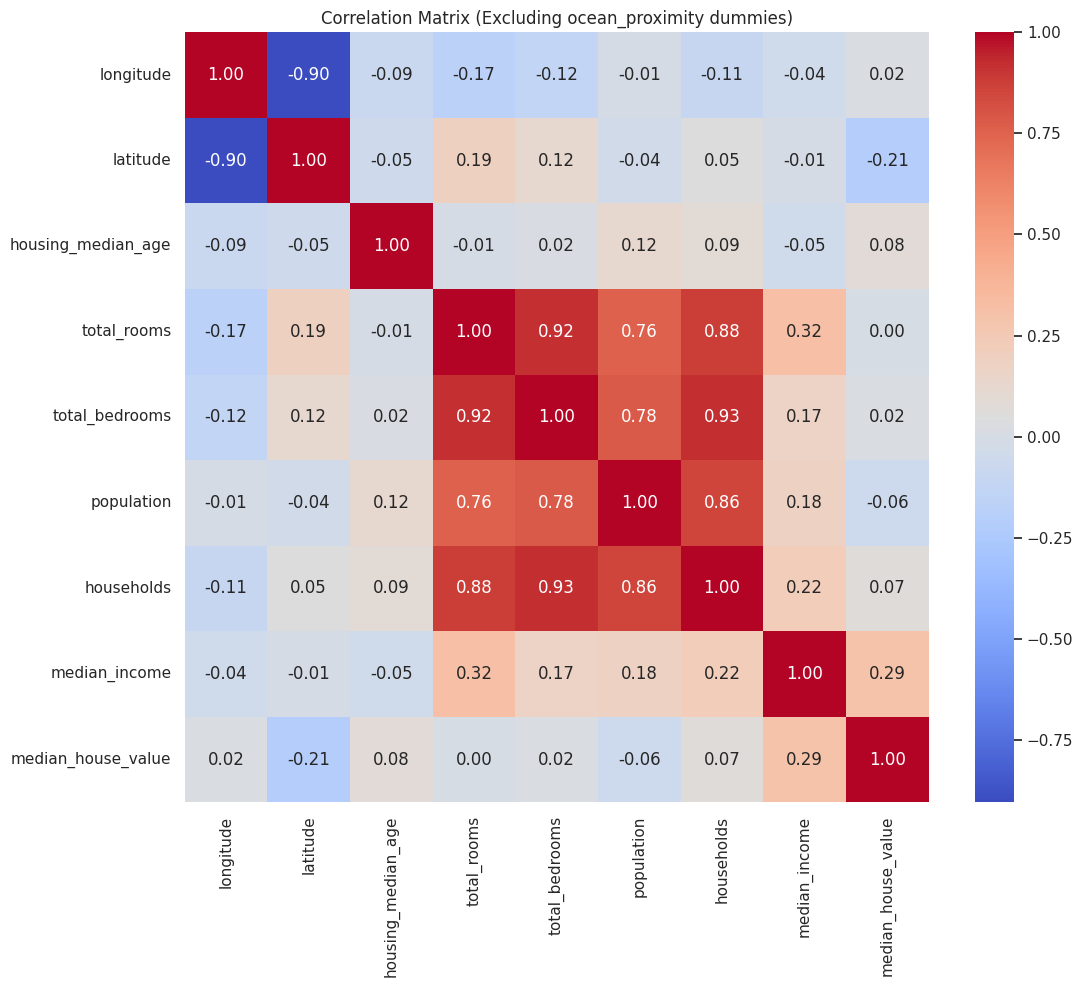

In [97]:
# Drop all one-hot encoded 'ocean_proximity_*' columns
filtered_df_corr = filtered_df.drop(columns=[col for col in filtered_df.columns if col.startswith('ocean_proximity_')])

# Correlation matrix
correlation_matrix = filtered_df_corr.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Excluding ocean_proximity dummies)')
plt.show()




##Chunk13(Splitting data to train and test)

In [98]:
# prompt: split the data to train and test

from sklearn.model_selection import train_test_split

# Assuming df2 is your preprocessed DataFrame
X = filtered_df.drop('median_house_value', axis=1)  # Features (all columns except target)
y = filtered_df['median_house_value']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% test

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1217, 8)
y_train shape: (1217,)
X_test shape: (305, 8)
y_test shape: (305,)


##Chunk14(Model Evaluation)

In [99]:
# Model Evaluation w/ Cross Validation
def modelEval(ldf,feature='median_house_value',model_id = 'dummy'):

    # Input: Feature & Target DataFrame

    # Split feature/target variable
    y = ldf[feature].copy()
    X = ldf.copy()
    del X[feature]     # remove target variable

    # Pick Model
    if(model_id == 'dummy'):    model = DummyRegressor()
    if(model_id == 'linear'):    model = LinearRegression()
    if(model_id == 'br'):    model = BR(verbose=False)
    if(model_id == 'rf'):    model = RandomForestRegressor(n_estimators=10,random_state=10)

    ''' Parameter Based Cross Validation (No Pipeline)'''
#     gscv = GridSearchCV(model,param_grid,cv=5)
#     gscv.fit(X,y)
#     results = pd.DataFrame(gscv.cv_results_)
#     scores = np.array(results.mean_test_score).reshape(7,7)

#     # plot the cross validation mean scores
#     heatmap1(scores,xlabel='lamda',xticklabels=param_grid['lamd'],
#                     ylabel='alpha',yticklabels=param_grid['alph'])

    ''' Standard Cross Validation '''
    cv_score = np.sqrt(-cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error'))
    print("Scores:",cv_score);print("Mean:", cv_score.mean());print("std:", cv_score.std())

##Chunk15(defining the models including "DummyRegressor", "Linear Regression", "BR"and "Random Forest Regression" and then the accuracy of each model)

In [100]:
# Define models
models = {
    "Dummy": DummyRegressor(),
    "Linear Regression": LinearRegression(),
    "br": BR(verbose=False),
    "rf": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Evaluate models
accuracy_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    accuracy = (1 - (rmse / (y.max() - y.min()))) * 100
    accuracy_results[name] = {"RMSE": round(rmse, 2), "Accuracy (%)": round(accuracy, 2)}

# Display the results
results_df = pd.DataFrame(accuracy_results).T
print("Test Set Evaluation Results:")
print(results_df)

Test Set Evaluation Results:
                       RMSE  Accuracy (%)
Dummy              76430.97         84.24
Linear Regression  63782.82         86.85
br                 76430.97         84.24
rf                 54856.40         88.69


##As you can see the accuracy of methodologies including Dummy, Linear Regression, BR and RF are higher than 84 %.